In [240]:
import requests
from bs4 import BeautifulSoup
import datetime
import os
import pymysql
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import collections

In [ ]:
from konlpy.tag import Okt,Mecab
import kss

from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional

In [2]:
ip_address = os.environ['AWS_IP']
PASSWORD = os.environ['SQL_PWD_AWS']

con = pymysql.connect(
    user='edward', 
    passwd=PASSWORD,
    host=ip_address, 
    db='community', 
    charset='utf8'
)

In [3]:
def nate_all_content():
    sql = f"select * from nate_content"
    with con.cursor() as cursor:
        cursor.execute(sql)
        result = cursor.fetchall()
    return result

In [29]:
def nate_all_comment():
    sql = f"select * from nate_comment"
    with con.cursor() as cursor:
        cursor.execute(sql)
        result = cursor.fetchall()
    df = pd.DataFrame(result)
    df.columns = ['id', 'like', 'dislike', 'content', 'article_id']
    return df

In [36]:
def fmk_all_comment():
    sql = f"select * from fmk_comment"
    with con.cursor() as cursor:
        cursor.execute(sql)
        result = cursor.fetchall()
    df = pd.DataFrame(result)
    df.columns = ['id', 'like', 'content', 'article_id']
    return df

In [31]:
okt = Okt()
mecab = Mecab()

In [26]:
# contents = nate_all_content()

In [32]:
comments_nate = nate_all_comment()

In [37]:
comments_fmk = fmk_all_comment()

## 전처리

In [596]:
'\"' in "aaa\"zz"

True

In [656]:
def to_morph(sentences):
    morphs = []
    for comment in tqdm(sentences):
        m = okt.pos(comment)
        m = [x[0] for x in m if x not in  ['\n', '.', ','] and x[1] not in ['Josa', 'Suffix']]
        morphs.append(m)
    return morphs

In [601]:
fmk_sentences = to_morph(comments_fmk['content'][:20000])

100%|██████████| 20000/20000 [06:44<00:00, 49.49it/s] 


In [602]:
nate_sentences = to_morph(comments_nate['content'][:20000])

100%|██████████| 20000/20000 [10:29<00:00, 31.75it/s]


## EDA

Text(0.5, 1.0, 'Histogram of morphemes per sentence')

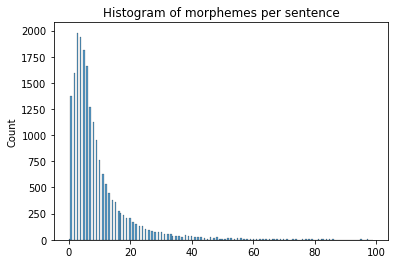

In [622]:
sns.histplot([len(x) for x in fmk_sentences if len(x) < 100]).set_title('Histogram of morphemes per sentence')

Text(0.5, 1.0, 'Histogram of morphemes per sentence')

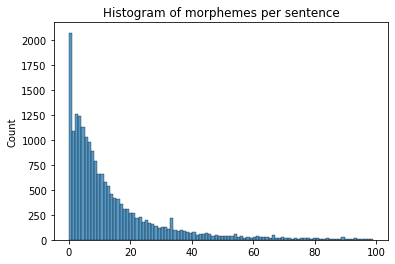

In [623]:
sns.histplot([len(x) for x in nate_sentences if len(x) < 100]).set_title('Histogram of morphemes per sentence')

In [624]:
def morph_count(sentences):
    temp = []
    for sen in sentences:
        temp.extend([x for  x in sen])
    return temp

In [625]:
fmk_morphs = morph_count(fmk_sentences)
nate_morphs = morph_count(nate_sentences)

In [626]:
collections.Counter(fmk_morphs).most_common(20)

[('?', 2313),
 ('ㅋㅋ', 1718),
 ('이', 1337),
 ('..', 1307),
 ('안', 1110),
 ('...', 1078),
 ('저', 1068),
 ('ㅋㅋㅋ', 957),
 ('거', 924),
 ('진짜', 914),
 ('잘', 838),
 ('때', 785),
 ('못', 760),
 ('한', 760),
 ('그', 754),
 ('사람', 705),
 ('다', 703),
 ('임', 636),
 ('생각', 627),
 ('말', 612)]

In [627]:
collections.Counter(nate_morphs).most_common(20)

[('..', 3293),
 ('?', 2978),
 ('...', 2544),
 ('진짜', 2335),
 ('안', 2228),
 ('다', 1937),
 ('이', 1931),
 ('사람', 1828),
 ('거', 1697),
 ('못', 1546),
 ('잘', 1540),
 ('내', 1520),
 ('그', 1514),
 ('나', 1406),
 ('때', 1405),
 ('말', 1335),
 ('애', 1307),
 ('저', 1287),
 ('생각', 1264),
 ('하는', 1207)]

In [628]:
print(f'fmk 고유 형태소 개수 : {len(set(fmk_morphs))}개')
print(f'nate 고유 형태소 개수 : {len(set(nate_morphs))}개')

fmk 고유 형태소 개수 : 35117개
nate 고유 형태소 개수 : 44217개


## Modeling

In [629]:
class DataSet:
    def __init__(self, fmk_sentences, nate_sentences):
        self.fmk_sentences = fmk_sentences 
        self.nate_sentences = nate_sentences

    def fit_tokenizer(self, vocab_size):
        self.tokenizer = Tokenizer(num_words = vocab_size)
        self.tokenizer.fit_on_texts(self.fmk_sentences + self.nate_sentences)
        
        self.sequences_fmk = self.tokenizer.texts_to_sequences(self.fmk_sentences)  
        self.sequences_nate = self.tokenizer.texts_to_sequences(self.nate_sentences)  
    
    def padding(self, max_length):
        self.pad_fmk = pad_sequences(self.sequences_fmk, padding='post', maxlen=max_length)
        self.pad_nate = pad_sequences(self.sequences_nate, padding='post', maxlen=max_length)
        
    def make(self):
        train = pd.DataFrame(self.pad_fmk)
        train['y'] = 0
        temp = pd.DataFrame(self.pad_nate)
        temp['y'] = 1
        train = train.append(temp)
        train = train[train.sum(axis=1) != 0]
        train = train.sample(len(train)).reset_index(drop=True)  # shufling
        X = train.iloc[:, :-1]
        y = train.iloc[:, -1]
        return X, y

In [630]:
#파라미터 설정
vocab_size = 8000
max_length = 15

In [631]:
Ds = DataSet(fmk_sentences, nate_sentences)
Ds.fit_tokenizer(vocab_size)
Ds.padding(max_length)
X, y = Ds.make()

In [634]:
embedding_dim = 200
model = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        # tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 32)),
        # Dense(28, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
model.compile(loss= 'binary_crossentropy',
              optimizer= 'adam',
              metrics = ['accuracy']) 
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 15, 200)           1600000   
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 15, 128)           135680    
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 1,776,961
Trainable params: 1,776,961
Non-trainable params: 0
_________________________________________________________________


In [635]:
history = model.fit(X, y, epochs=5, batch_size=48, validation_split= 0.15) 

Epoch 1/5
698/698 [==============================] - 41s 58ms/step - loss: 0.4704 - accuracy: 0.7628 - val_loss: 0.4066 - val_accuracy: 0.8097
Epoch 2/5
698/698 [==============================] - 32s 46ms/step - loss: 0.3221 - accuracy: 0.8534 - val_loss: 0.4025 - val_accuracy: 0.8085
Epoch 3/5
698/698 [==============================] - 30s 43ms/step - loss: 0.2514 - accuracy: 0.8864 - val_loss: 0.4774 - val_accuracy: 0.8104
Epoch 4/5
698/698 [==============================] - 30s 43ms/step - loss: 0.1982 - accuracy: 0.9090 - val_loss: 0.5571 - val_accuracy: 0.7956
Epoch 5/5
698/698 [==============================] - 30s 42ms/step - loss: 0.1591 - accuracy: 0.9254 - val_loss: 0.6224 - val_accuracy: 0.7953


In [306]:
# pred = model.predict(X)

## 예측

In [783]:
type('123')

str

In [784]:
def sentences_to_seq(sentences, tokenizer):
    if type(sentences) == str:
        sentences = [sentences]
    morphs_list = to_morph(sentences)
    sequences = tokenizer.texts_to_sequences(morphs_list)
    empty = [idx for idx, x in enumerate(sequences) if not x]
    X_test = pad_sequences(sequences, padding='post', maxlen=max_length)
#     return sequences
    pred = model.predict(X_test)
    for i in empty:
        pred[i] = [None]
    return pred

In [787]:
sentences_to_seq('ㅋㅋㅋ', Ds.tokenizer)

100%|██████████| 1/1 [00:00<00:00, 504.18it/s]


array([[0.23743169]], dtype=float32)

In [659]:
pred_fmk = sentences_to_seq(comments_fmk['content'][20000:20500], Ds.tokenizer)
pred_nate = sentences_to_seq(comments_nate['content'][20000:20500], Ds.tokenizer)

100%|██████████| 500/500 [00:17<00:00, 28.82it/s]  


In [660]:
pred_fmk = [x for x in pred_fmk if x != None]
pred_nate = [x for x in pred_nate if x != None]

In [661]:
np.mean(pd.DataFrame(pred_fmk) > 0.5)

0    0.244
dtype: float64

In [662]:
np.mean(pd.DataFrame(pred_nate) > 0.5)

0    0.692
dtype: float64

In [766]:
okt.pos('공채라네요')

[('공채', 'Noun'), ('라네', 'Josa'), ('요', 'Noun')]

In [790]:
sentences_to_seq(['너 어제 왜그랬어?', '어제 왜 그럼?'], Ds.tokenizer)

100%|██████████| 2/2 [00:00<00:00, 686.24it/s]


array([[0.78080094],
       [0.17026658]], dtype=float32)

In [803]:
sentences_to_seq(['뭐하나?', '뭐하고있엉?'], Ds.tokenizer)

100%|██████████| 2/2 [00:00<00:00, 542.67it/s]


array([[0.3315458 ],
       [0.80688167]], dtype=float32)

## 모델 저장

In [805]:
model.save("lstm_model.h5")

In [806]:
import pickle

In [807]:
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(Ds.tokenizer, f)